# Before you use this template

This template is just a recommended template for project Report. It only considers the general type of research in our paper pool. Feel free to edit it to better fit your project. You will iteratively update the same notebook submission for your draft and the final submission. Please check the project rubriks to get a sense of what is expected in the template.

---

# FAQ and Attentions
* Copy and move this template to your Google Drive. Name your notebook by your team ID (upper-left corner). Don't eidt this original file.
* This template covers most questions we want to ask about your reproduction experiment. You don't need to exactly follow the template, however, you should address the questions. Please feel free to customize your report accordingly.
* any report must have run-able codes and necessary annotations (in text and code comments).
* The notebook is like a demo and only uses small-size data (a subset of original data or processed data), the entire runtime of the notebook including data reading, data process, model training, printing, figure plotting, etc,
must be within 8 min, otherwise, you may get penalty on the grade.
  * If the raw dataset is too large to be loaded  you can select a subset of data and pre-process the data, then, upload the subset or processed data to Google Drive and load them in this notebook.
  * If the whole training is too long to run, you can only set the number of training epoch to a small number, e.g., 3, just show that the training is runable.
  * For results model validation, you can train the model outside this notebook in advance, then, load pretrained model and use it for validation (display the figures, print the metrics).
* The post-process is important! For post-process of the results,please use plots/figures. The code to summarize results and plot figures may be tedious, however, it won't be waste of time since these figures can be used for presentation. While plotting in code, the figures should have titles or captions if necessary (e.g., title your figure with "Figure 1. xxxx")
* There is not page limit to your notebook report, you can also use separate notebooks for the report, just make sure your grader can access and run/test them.
* If you use outside resources, please refer them (in any formats). Include the links to the resources if necessary.

# Introduction
This is an introduction to your report, you should edit this text/mardown section to compose. In this text/markdown, you should introduce:

*   Background of the problem
  * what type of problem: disease/readmission/mortality prediction,  feature engineeing, data processing, etc
  * what is the importance/meaning of solving the problem
  * what is the difficulty of the problem
  * the state of the art methods and effectiveness.
*   Paper explanation
  * what did the paper propose
  * what is the innovations of the method
  * how well the proposed method work (in its own metrics)
  * what is the contribution to the reasearch regime (referring the Background above, how important the paper is to the problem).


In [ ]:
# code comment is used as inline annotations for your coding

# Scope of Reproducibility:

List hypotheses from the paper you will test and the corresponding experiments you will run.

1.   Hypothesis: The DuETT's attention to both time and event types will yield more comprehensive EHR data representations and result in improved performance over other methods (XGBoost, LSTM, mTAND, Raindrop, STraTs) on the PhysioNet-2012 mortality task.

Experiments:

1. We will run the DuETT model on the PhysioNet-2012 mortality task using the same training parameter inorder to validate and replicate the original paper result.

Ablations planned:

1.   Input representation ablations: 
      - Investigate the use of the last occurring value in the bin as the aggregation functions of bins by comparing the performance with other methods (mean, max). 
      - Investigate the choice of injecting event & time embedding at each layer which should by only injecting at the first layer.
2.   Self-Supervised Learning Ablation: 
      - Investigate the impact of pre-training by skipping it entirely.
3.   Dual event & time transformer Ablation: 
      - Investigate the impact of having both event and time transformers by only having either event or time transformers.



# Methodology

This methodology is the core of your project. It consists of run-able codes with necessary annotations to show the expeiment you executed for testing the hypotheses.

The methodology at least contains two subsections **data** and **model** in your experiment.

In [ ]:
# Install necessary packages

%pip install -r requirements.txt

In [76]:
import numpy as np
import pytorch_lightning as pl
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchmetrics
import torch.nn.functional as F
import torch.nn as nn
import x_transformers

# Code based on Authors' Public Repository
import duett
import physionet
import train

In [7]:
# Use same seed as paper

seed = 2020
pl.seed_everything(seed)

Global seed set to 2020


2020

##  Data
Data includes raw data (MIMIC III tables), descriptive statistics (our homework questions), and data processing (feature engineering).
  * Source of the data: where the data is collected from; if data is synthetic or self-generated, explain how. If possible, please provide a link to the raw datasets.
  * Statistics: include basic descriptive statistics of the dataset like size, cross validation split, label distribution, etc.
  * Data process: how do you munipulate the data, e.g., change the class labels, split the dataset to train/valid/test, refining the dataset.
  * Illustration: printing results, plotting figures for illustration.
  * You can upload your raw dataset to Google Drive and mount this Colab to the same directory. If your raw dataset is too large, you can upload the processed dataset and have a code to load the processed dataset.

## Dataset

The PhysioNet/Computing in Cardiology Challenge 2012: Predicting Mortality of ICU Patients

### Source of Data

This data consists of records from 12000 ICU stays and is accessed for this project through torchtime.data as well as from the official physionet website: https://physionet.org/content/challenge-2012/1.0.0/

### Data Descriptors

1. 37 Time Series Variales:

    0. Mins: Minutes since ICU admission. Derived from the PhysioNet time stamp.
    1. Albumin: Albumin (g/dL)
    2. ALP: Alkaline phosphatase (IU/L)
    3. ALT: Alanine transaminase (IU/L)
    4. AST: Aspartate transaminase (IU/L)
    5. Bilirubin: Bilirubin (mg/dL)
    6. BUN: Blood urea nitrogen (mg/dL)
    7. Cholesterol: Cholesterol (mg/dL)
    8. Creatinine: Serum creatinine (mg/dL)
    9. DiasABP: Invasive diastolic arterial blood pressure (mmHg)
    10. FiO2: Fractional inspired O\ :sub:`2` (0-1)
    11. GCS: Glasgow Coma Score (3-15)
    12. Glucose: Serum glucose (mg/dL)
    13. HCO3: Serum bicarbonate (mmol/L)
    14. HCT: Hematocrit (%)
    15. HR: Heart rate (bpm)
    16. K: Serum potassium (mEq/L)
    17. Lactate: Lactate (mmol/L)
    18. Mg: Serum magnesium (mmol/L)
    19. MAP: Invasive mean arterial blood pressure (mmHg)
    20. MechVent: Mechanical ventilation respiration (0:false, or 1:true)
    21. Na: Serum sodium (mEq/L)
    22. NIDiasABP: Non-invasive diastolic arterial blood pressure (mmHg)
    23. NIMAP: Non-invasive mean arterial blood pressure (mmHg)
    24. NISysABP: Non-invasive systolic arterial blood pressure (mmHg)
    25. PaCO2: Partial pressure of arterial CO\ :sub:`2` (mmHg)]
    26. PaO2: Partial pressure of arterial O\ :sub:`2` (mmHg)
    27. pH: Arterial pH (0-14)
    28. Platelets: Platelets (cells/nL)
    29. RespRate: Respiration rate (bpm)
    30. SaO2: O\ :sub:`2` saturation in hemoglobin (%)
    31. SysABP: Invasive systolic arterial blood pressure (mmHg)
    32. Temp: Temperature (°C)
    33. TroponinI: Troponin-I (μg/L). Note this is labelled *TropI* in the PhysioNet
        data dictionary.
    34. TroponinT: Troponin-T (μg/L). Note this is labelled *TropT* in the PhysioNet
        data dictionary.
    35. Urine: Urine output (mL)
    36. WBC: White blood cell count (cells/nL)

2. General Descriptors:

    37. Weight: Weight (kg)
    38. Age: Age (years) at ICU admission
    39. Gender: Gender (0: female, or 1: male)
    40. Height: Height (cm) at ICU admission
    41. ICUType1: Type of ICU unit (1: Coronary Care Unit)
    42. ICUType2: Type of ICU unit (2: Cardiac Surgery Recovery Unit)
    43. ICUType3: Type of ICU unit (3: Medical ICU)
    44. ICUType4: Type of ICU unit (4: Surgical ICU)

3. Outcome-related Descriptors

    1. RecordID 
    2. SAPS-I score (Le Gall et al., 1984)
    3. SOFA score (Ferreira et al., 2001)
    4. Length of stay (days)
    5. Survival (days)
    6. In-hospital death (0: survivor, or 1: died in-hospital)



In [8]:
dm = physionet.PhysioNetDataModule(batch_size=512, num_workers=16, use_temp_cache=True)
dm.setup()

100%|██████████| 7.57M/7.57M [00:11<00:00]


100%|██████████| 7.59M/7.59M [00:11<00:00]


100%|██████████| 6.29M/6.29M [00:09<00:00]


Processing data...


100%|██████████| 4000/4000 [01:28<00:00]


Validating cache...
Validating cache...


## Statistics

Total Sample Size:  12000
Train Split:  8400  Val Split:  1800  Test Split:  1800


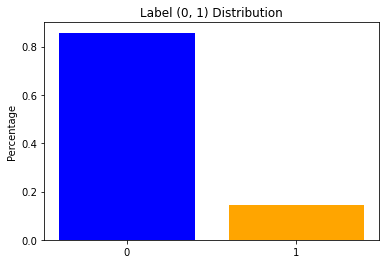

In [48]:
train_set = dm.ds_train
val_set = dm.ds_val
test_set = dm.ds_test

total_size = len(train_set) + len(val_set) + len(test_set)

print("Total Sample Size: ", total_size)
print("Train Split: ", len(train_set), " Val Split: ",  len(val_set), " Test Split: ", len(test_set))

# Label distribution
count_0 = (train_set.y == 0).sum() + (val_set.y == 0).sum() + (test_set.y == 0).sum()
percentage = (count_0 / total_size)

plt.bar(['0', '1'], [percentage, 1 - percentage], color=['blue', 'orange'])
plt.title('Label (0, 1) Distribution')
plt.ylabel('Percentage')
plt.show()

## Data Process

### Splitting Data

This Physio2012 has predefined train/val/test splits given when loading data 


### Input Representation Processing

Input data X includes 37 Time Series data and 6 General Descriptors. 

We process the 37 Time Series data by splitting the full sequence of each of the patient's time series event into equal lengthed bins. This results in a 2d binned input matrix of shape (37 event type, # bins) where each bin contains a value that is the aggregation of values that occured within that bin's time frame. This aggregation can be the mean, max, min or last value observed for that bin.

This transforms the irregular input data into regularly sampled data with bin number acting as a control over the trade-off between information granularity and computational complexity.

We seperatly collect the General Descriptors as static input

Final x representation:
  -  x = (Binned event values, General Descriptors, Bin Boundaries)

Final y representation:
  -  y = In-hospital death (0: survivor, or 1: died in-hospital)


In [69]:
# Code snippet for processing each data point (x, y) based on public repo

def __getitem__(self, i):
    ins = self.X[i, ~torch.isnan(self.X[i,:,0]), :]
    time = ins[:,0] / 60 / 24
    x_static = torch.zeros(self.d_static_num())

	# Split patient events into bins of equal length, and use last ocurring value in each bin as representative value
    x_ts = torch.zeros((self.n_timesteps, self.d_time_series_num()*2))
    for i_t, t in enumerate(time):
        bin = self.n_timesteps - 1 if t == time[-1] else int(t / time[-1] * self.n_timesteps)
        for i_ts in range(1,37):
            x_i = ins[i_t,i_ts]
            if not torch.isnan(x_i).item():
                x_ts[bin, i_ts-1] = (x_i - self.means[i_ts])/(self.stds[i_ts] + 1e-7)
                x_ts[bin, i_ts-1+self.d_time_series_num()] += 1
    bin_ends = torch.arange(1, self.n_timesteps+1) / self.n_timesteps * time[-1]

	# Collect General Descriptors as static input variables
    for i_tab in range(37,45):
        x_i = ins[0, i_tab]
        x_i = (x_i - self.means[i_tab])/(self.stds[i_tab] + 1e-7)
        x_static[i_tab-37] = x_i.nan_to_num(0.)

	# Final x representation, (Binned event values, General Descriptors, Bin Boundaries)
    x = (x_ts, x_static, bin_ends)
    
	# Final y representation, (0: survivor, or 1: died in-hospital)
    y = self.y[i,0]
    if self.temp_cache is not None:
        self.temp_cache[i] = (x, y)

    return x, y

x, y  = dm.ds_train.__getitem__(0)

print("x: (Binned event values, General Descriptors, Bin Boundaries)")
print("x Shape: ", (x[0].shape, x[1].shape, x[2].shape))


x: (Binned event values, General Descriptors, Bin Boundaries)
x Shape:  (torch.Size([32, 72]), torch.Size([8]), torch.Size([32]))


##   Model
The model includes the model definitation which usually is a class, model training, and other necessary parts.
  * Model architecture: layer number/size/type, activation function, etc
  * Training objectives: loss function, optimizer, weight of each loss term, etc
  * Others: whether the model is pretrained, Monte Carlo simulation for uncertainty analysis, etc
  * The code of model should have classes of the model, functions of model training, model validation, etc.
  * If your model training is done outside of this notebook, please upload the trained model here and develop a function to load and test it.

## Model Architecture:

Model Architecture is implemented and imported from duett.py (Based on Public Paper Repo)

The model consists of a series of DuETT layers followed by classification or self-supervised learning heads.  Each DuETT layer has 2 transformer sublayers that attend to the event and time dimension of the embedding respectively.

The first sublayer (Event transformer) has a multi-head attention over events followed by a feed-forward network in the event dimension.

The second sublayer (Time transformer) has a multi-head attention over time bins followed by a feed-forward network operating along the time dimension


## Pretraining

Uses masked event modeling to train the model to capture important priors. This masking scheme is done along both time and event dimensions and predicts both the presence and absence of an event. 

In [78]:
# Pre-training Code

pretrain_model = duett.pretrain_model(d_static_num=dm.d_static_num(),
        d_time_series_num=dm.d_time_series_num(), d_target=dm.d_target(), pos_frac=dm.pos_frac(),
        seed=seed)
checkpoint = pl.callbacks.ModelCheckpoint(save_last=True, monitor='val_loss', mode='min', save_top_k=1, dirpath='checkpoints')
warmup = train.WarmUpCallback(steps=2000)
trainer = pl.Trainer(gpus=1, logger=False, num_sanity_val_steps=2, max_epochs=300,
        gradient_clip_val=1.0, callbacks=[warmup, checkpoint])
trainer.fit(pretrain_model, dm)

warmup_steps 2000, base_lr None, invsqrt True, decay None


/Users/josephjang/opt/anaconda3/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/Users/josephjang/opt/anaconda3/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


MisconfigurationException: GPUAccelerator can not run on your system since the accelerator is not available. The following accelerator(s) is available and can be passed into `accelerator` argument of `Trainer`: ['cpu'].

In [ ]:

class my_model():
  # use this class to define your model
  pass

model = my_model()
loss_func = None
optimizer = None

def train_model_one_iter(model, loss_func, optimizer):
  pass

num_epoch = 10
# model training loop: it is better to print the training/validation losses during the training
for i in range(num_epoch):
  train_model_one_iter(model, loss_func, optimizer)
  train_loss, valid_loss = None, None
  print("Train Loss: %.2f, Validation Loss: %.2f" % (train_loss, valid_loss))


# Results
In this section, you should finish training your model training or loading your trained model. That is a great experiment! You should share the results with others with necessary metrics and figures.

Please test and report results for all experiments that you run with:

*   specific numbers (accuracy, AUC, RMSE, etc)
*   figures (loss shrinkage, outputs from GAN, annotation or label of sample pictures, etc)


In [ ]:
# metrics to evaluate my model

# plot figures to better show the results

# it is better to save the numbers and figures for your presentation.

## Model comparison

In [ ]:
# compare you model with others
# you don't need to re-run all other experiments, instead, you can directly refer the metrics/numbers in the paper

# Discussion

In this section,you should discuss your work and make future plan. The discussion should address the following questions:
  * Make assessment that the paper is reproducible or not.
  * Explain why it is not reproducible if your results are kind negative.
  * Describe “What was easy” and “What was difficult” during the reproduction.
  * Make suggestions to the author or other reproducers on how to improve the reproducibility.
  * What will you do in next phase.



In [ ]:
# no code is required for this section
'''
if you want to use an image outside this notebook for explanaition,
you can read and plot it here like the Scope of Reproducibility
'''

# References

1.   Sun, J, [paper title], [journal title], [year], [volume]:[issue], doi: [doi link to paper]



# Feel free to add new sections